# The contrast-dependence of spatial frequency tuning
## Thesis chapter 1/publication

Here, we'll organize (better than has been organized in the predecesor notebooks __{analysis_ch1, analysis_ch1_suppl, descrAnalysisV1-allExps, V1_clustering, and descrAnalysisLGN]}__ the analysis for chapter 1 of my thesis. The primary intention behind re-doing this notebook (_again_) is that per a meeting in April 2022, Tony and Eero suggested we write this chapter as a paper fit for publication.

In particular, writing this chapter as a paper necessitates re-doing some of the analyses from Sach Sokol's thesis (specifically, his 3rd chapter).

In [364]:
import helper_fcns as hf
import numpy as np

import warnings
warnings.filterwarnings(action='once')

import os
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

# what's the save name for this analysis?
saveName = 'figures/reports/ch01_sfTuning_contrast/'; # for one save name for all figures
save_loc = base_dir + saveName;

In [365]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

# 1.1 LGN

### 1.1.01 - Scaled vs. separate Difference-of-Gaussians (DoG) 

The first key analysis in Sach's thesis is showing that spatial frequency tuning is contrast dependent. Using a $\chi^2$ analysis, he shows that despite using extra parameters, a separate-per-contrast Difference-of-Gaussians (DoG) model outperforms a scaled DoG model. In the scaled model, the shapes and relative magnitudes of the gaussians are fixed, and the resultant curve can only be shifted vertically (i.e. changing response magnitude).

As of 22.04.20, we will not replicate this analysis, taking it as a well-justified in the literature.

### 1.1.02 - Determining which DoG parameters matter most

In section 3.3.4 (_Which DoG parameters can account for contrast-dependent tuning?_), Sach asks which of the DoG parameters are most needed to be adjustable across contrast. Using the more common approaches of the time (thesis defended in 2009), he used a $\chi^2$ analysis which compared the loss of each model while taking into account the number of free parameters. Since computational resources and accessibility have greatly improved in the interim period, we'll instead use cross-validation to compare the different models.

#### The models
- $\Delta$_volume ratio_ (2*$n_{con}$ + 2 free parameters) - center and surround radii are fixed
- $\Delta$_center radius_ (2*$n_{con}$ + 2 free parameters) - surround radius and relative surround gain are fixed
    - Note that the surround radius is fixed in absolute terms
- $\Delta$_surround radius_ (2*$n_{con}$ + 2 free parameters) - center radius and relative surround gain are fixed
- $\Delta$_center-surround_ (3*$n_{con}$ + 1 free parameters) - relative surround gain is fixed

And for thorough comparison, we also include the model with which most prior analysis was done

- $\Delta$_center radius + vol_ (3*$n_{con}$ + 1 free parameters) - relative surround radius is fixed
    - This model differs from $\Delta$_center radius_ in that the surround radius is fixed in relative terms to the center radius at contrast. Further, the relative Gaussian volumes are allowed to changed (since the relative surround gain term is free at each contrast)

#### Cross-validation
In cross-validation, we partition the data into training and test, optimizing the model jointly across all contrasts based only on the training data. We then evaluate the model on the heldout (i.e. test) portion of the data, and assess the loss function. If model X has better training performance than model Y but worse test performance, then we can say that model X is simply overfitting the data. For example, we know that a well-parameterized model with more free parameters will outperform one with fewer parameters; however, how those models perform on heldout data is a better measure of the model's explanatory capabilities.


#### Model performance (all data)
First, we'll compare the model performance when fitting to all of the data.

In [366]:
# Specify which data to load
date = '220504'
# date = '220423'
isHPC = 1;
expDir = 'LGN'
loss_type = 2;
dog_model = 1;
dogName = 'descrFits%s_%s' % ('HPC' if isHPC else '', date);

joints = [2,3,4,5,6];
# NOTE: Yes, the naming convention for surr/center radius models are reversed from the fit names
# --- that's because here (and in Sach's thesis) we model the name by what does shift
# --- in my naming convention, we name it after what does NOT shift with contrast
names = ['ctr. r. + vol', 'vol. ratio', 'surr. r', 'ctr. r', 'ctr-surr'];
nMods = len(joints);
ref_ind = 0; # in the index of the joints that we'll use as the reference
nFreeParams = [3,2,2,2,3]; # how many free params per condition?
param_color = ['', '', 'r', 'k']; # what color based on # params per condition

ref_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=joints[ref_ind])));
nCells = len(ref_mod.keys());

# Now, organize all of the loss values - raw and normalized by the reference models
raw_ind = 0;
norm_ind = 1;
nlls_all = np.nan * np.zeros((nCells, nMods, 2)); # end is [raw_ind, norm_ind]

for i,j in enumerate(joints):
    curr_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=j)));
    nlls_all[:, i, 0] = np.array([curr_mod[x]['totalNLL'][0] for x in range(nCells)]);
    
# then normalize, too:
nlls_all[:,:,1] = np.divide(nlls_all[:,:,0], np.repeat(np.transpose([nlls_all[:,ref_ind,0]]), nMods, axis=1))

Now plot the distributions of losses across all cells (again, this is fitting to all data)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


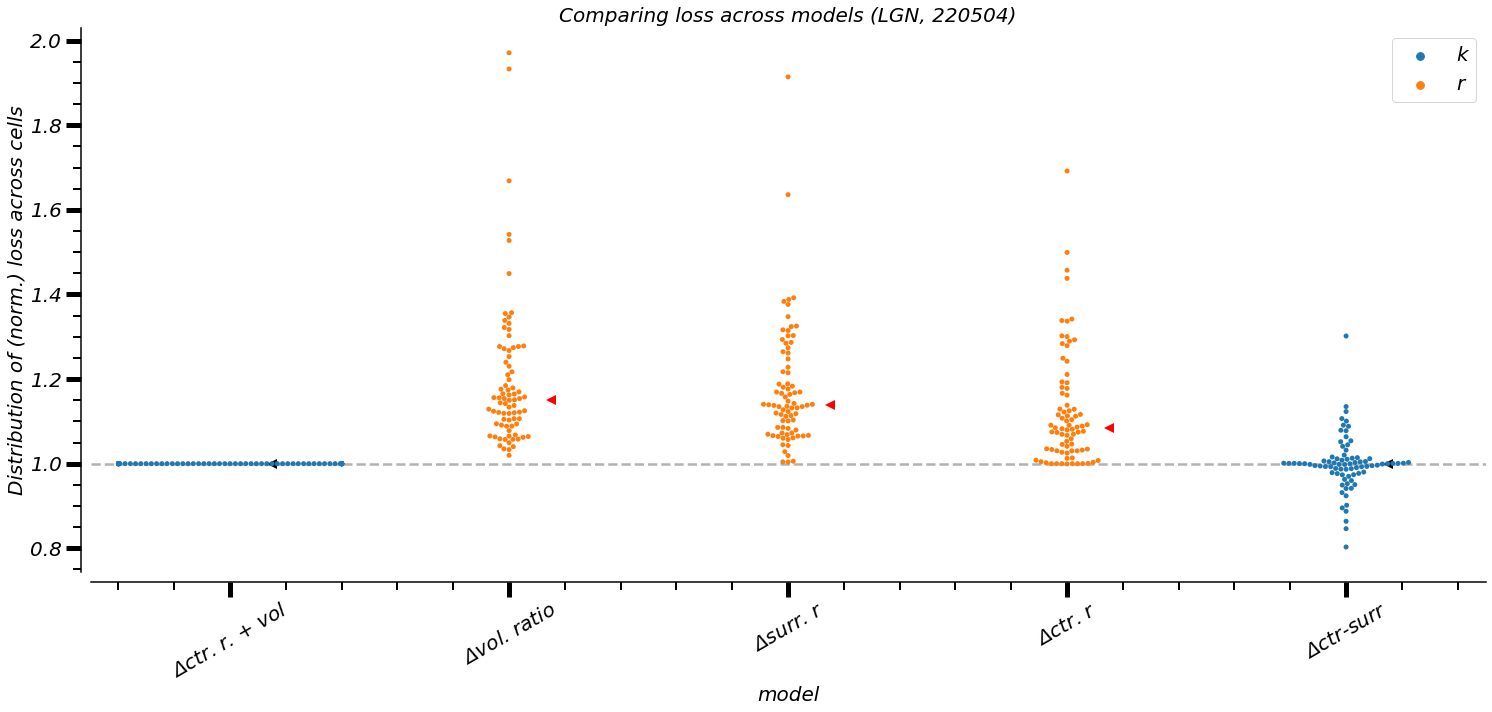

In [367]:
use_norm = 1;

f = plt.figure(figsize=(5*nMods, 10));

# for ind in range(nMods):
    
#     sns.swarmplot(y=nlls_all[:,ind,use_norm], x=[ind]);
#     viol = plt.violinplot(dataset=nlls_all[:,ind,use_norm], positions=[ind], showextrema=False, widths=0.7);

#     # make all the violin stuff black and transparent
#     for vp in viol['bodies']:
#         vp.set_color(param_color[nFreeParams[ind]])
#         vp.set_alpha(0.2);

[plt.plot(i+0.15, np.nanmedian(nlls_all[:,i,use_norm]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)]
sns.swarmplot(x=np.tile(np.arange(nMods), nCells), y=hf.flatten_list(nlls_all[:,:,use_norm]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nCells));
sns.despine(offset=10)

if use_norm:
    plt.axhline(1, color='k', linestyle='--', alpha=0.3)

plt.xlabel('model');
plt.ylabel('Distribution of %sloss across cells' % '(norm.) ' if use_norm else '');
plt.xticks(ticks=np.arange(nMods), labels=[r'$\Delta$%s' % x for x in names], rotation=30);
plt.title('Comparing loss across models (LGN, %s)' % date);

saveName = "/01_01_02a_loss_nonCV_%s%s.pdf" % (date, '_norm' if use_norm else '');
curr_dir = os.path.dirname(save_loc+saveName);
if not os.path.exists(curr_dir):
    os.makedirs(curr_dir);
pdfSv = pltSave.PdfPages(save_loc + saveName);
pdfSv.savefig(f); # only one figure here...
pdfSv.close()

Not surprisingly, the two models on the edges of the plot (_ctr. r. + vol_ and _ctr-surr_) with the greatest number of parameters outperform the others. Also unsurprisingly, the model in which the center radius is fixed (i.e. $\Delta$_surr. r_) is poor, since we know that change in center radius is a very prominent in the data.

_Note that the one cell outlier for which the models with fewer parameters outperform the reference model is basically just noise (LGN cell 25)_

#### Cross-validation, train fraction = 0.8

As a first attempt, we keep 80% of the data for training and holdout the remaining for testing. We'll first show the training performance and then show loss on test performance.

In [375]:
# Specify which data to load
date = '220504'
isHPC = 1;
expDir = 'LGN'
loss_type = 1;
dog_model = 1;
has_tr_subset = True;
dogName = 'descrFits%s_%s' % ('HPC' if isHPC else '', date);

joints = [3,4,5];
# joints = [2,3,4,5,6];
# NOTE: Yes, the naming convention for surr/center radius models are reversed from the fit names
# --- that's because here (and in Sach's thesis) we model the name by what does shift
# --- in my naming convention, we name it after what does NOT shift with contrast
names = ['vol. ratio', 'surr. r', 'ctr. r'];
# names = ['ctr. r. + vol', 'vol. ratio', 'surr. r', 'ctr. r', 'ctr-surr'];
nMods = len(joints);
ref_ind = 0; # in the index of the joints that we'll use as the reference
nFreeParams = [2,2,2]; # how many free params per condition?
# nFreeParams = [3,2,2,2,3]; # how many free params per condition?
param_color = ['', '', 'r', 'k']; # what color based on # params per condition

ref_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=joints[ref_ind])));
nCells = len(ref_mod.keys());
nBoots = ref_mod[0]['boot_paramList'].shape[0];

# Now, organize all of the loss values - raw and normalized by the reference models
raw_ind = 0;
norm_ind = 1;
nlls_train_all = np.nan * np.zeros((nCells, nBoots, nMods, 2)); # end is [raw_ind, norm_ind]
nlls_train_subset_all = np.nan * np.zeros((nCells, nBoots, nMods, 2)); # end is [raw_ind, norm_ind]
nlls_test_all = np.copy(nlls_train_all)

for i,j in enumerate(joints):
    curr_mod = hf.np_smart_load('%s/structures/%s' % (expDir, hf.descrFit_name(loss_type, descrBase=dogName, modelName=hf.descrMod_name(dog_model), joint=j)));
#     nlls_train_all[:, :, i, 0] = [np.nansum(curr_mod[x]['boot_NLL_cv_train'][0][:,0,:], axis=1) for x in range(nCells)];
#     nlls_test_all[:, :, i, 0] = [np.nansum(curr_mod[x]['boot_NLL_cv_test'][0][:,0,:], axis=1) for x in range(nCells)];
#     if has_tr_subset:
#         nlls_train_subset_all[:, :, i, 0] = [np.nansum(curr_mod[x]['boot_NLL_cv_train_subset'][0][:,0,:], axis=1) for x in range(nCells)];
    for c in range(nCells):
        if 'boot_NLL_cv_train' in curr_mod[c]:
            nlls_train_all[c, :, i, 0] = np.nansum(curr_mod[c]['boot_NLL_cv_train'][0][:,0,:], axis=1);
        if 'boot_NLL_cv_test' in curr_mod[c]:
            nlls_test_all[c, :, i, 0] = np.nansum(curr_mod[c]['boot_NLL_cv_test'][0][:,0,:], axis=1)
        if has_tr_subset and 'boot_NLL_cv_train_subset' in curr_mod[c]:
            nlls_train_subset_all[c, :, i, 0] = np.nansum(curr_mod[c]['boot_NLL_cv_train_subset'][0][:,0,:], axis=1)


# then, normalize, too:
nlls_train_all[:,:,:,1] = np.divide(nlls_train_all[:,:,:,0], np.expand_dims(np.nanmin(nlls_train_all[:,:,ref_ind,0], axis=1), axis=(1,2)))
nlls_test_all[:,:,:,1] = np.divide(nlls_test_all[:,:,:,0], np.expand_dims(np.nanmin(nlls_test_all[:,:,ref_ind,0], axis=1), axis=(1,2)))
if has_tr_subset:
    nlls_train_subset_all[:,:,:,1] = np.divide(nlls_train_subset_all[:,:,:,0], np.expand_dims(np.nanmin(nlls_train_subset_all[:,:,ref_ind,0], axis=1), axis=(1,2)))


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: All-NaN slice encountered


In [376]:
lbl = ['train', 'subset(tr)', 'test']
all_data = [nlls_train_all, nlls_train_subset_all, nlls_test_all]
# lbl = ['train', 'test']
# all_data = [nlls_train_all, nlls_test_all]

nComps = len(lbl);

for cell_num in range(nCells):

    sharey = True if nComps>2 else False;
    f, ax = plt.subplots(1, nComps, figsize=(nComps*10,10), sharey=sharey);

#     # train
#     sns.swarmplot(x=np.tile(np.arange(nMods), nBoots), y=hf.flatten_list(nlls_train_all[cell_num,:,:,0]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nBoots), alpha=0.5, ax=ax[0]);
#     [ax[0].plot(i+0.25, np.nanmean(nlls_train_all[cell_num,:,i,0]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)];

#     # test
#     sns.swarmplot(x=np.tile(np.arange(nMods), nBoots), y=hf.flatten_list(nlls_test_all[cell_num,:,:,0]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nBoots), alpha=0.5, ax=ax[1]);
#     [ax[1].plot(i+0.25, np.nanmean(nlls_test_all[cell_num,:,i,0]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)];

    for j,dta in enumerate(all_data):
        sns.swarmplot(x=np.tile(np.arange(nMods), nBoots), y=hf.flatten_list(dta[cell_num,:,:,0]), hue=np.tile([param_color[nFreeParams[x]] for x in range(nMods)], nBoots), alpha=0.5, ax=ax[j]);
        [ax[j].plot(i+0.25, np.nanmean(dta[cell_num,:,i,0]), '<', color=param_color[nFreeParams[i]], markersize=10) for i in range(nMods)];

    sns.despine(offset=10)
    f.suptitle('Comparing models with cross-validation')

    for i in range(nComps):
        ax[i].set_xlabel('Model');
        ax[i].set_ylabel('Loss per joint fit')
        ax[i].set_title('%s' % lbl[i]);
        ax[i].set_xticklabels(labels=[r'$\Delta$%s' % x for x in names], rotation=30);

    saveName = "/01_01_02b_comps_%s/cell_%03d.pdf" % (date, cell_num+1);
    curr_dir = os.path.dirname(save_loc+saveName);
    if not os.path.exists(curr_dir):
        os.makedirs(curr_dir);
    pdfSv = pltSave.PdfPages(save_loc + saveName);
    pdfSv.savefig(f); # only one figure here...
    pdfSv.close()
    f.clf();

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_laun

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_laun

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>

<Figure size 2160x720 with 0 Axes>